In [1]:
get_ipython().magic('matplotlib inline')
get_ipython().magic('config InlineBackend.figure_format = "retina"')

import matplotlib.pyplot as pl

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
from configobj import ConfigObj
from astropy import constants as c
from astropy import units as u
import pprint

import limbdark

pp = pprint.PrettyPrinter(indent=2)

def map_int(x):
    return list(map(int, x))

def map_float(x):
    return list(map(float, x))

sys.path.append('..')
from transitfit import TransitFit
from transitfit.util import mad_outliers, get_init_params, u_to_q

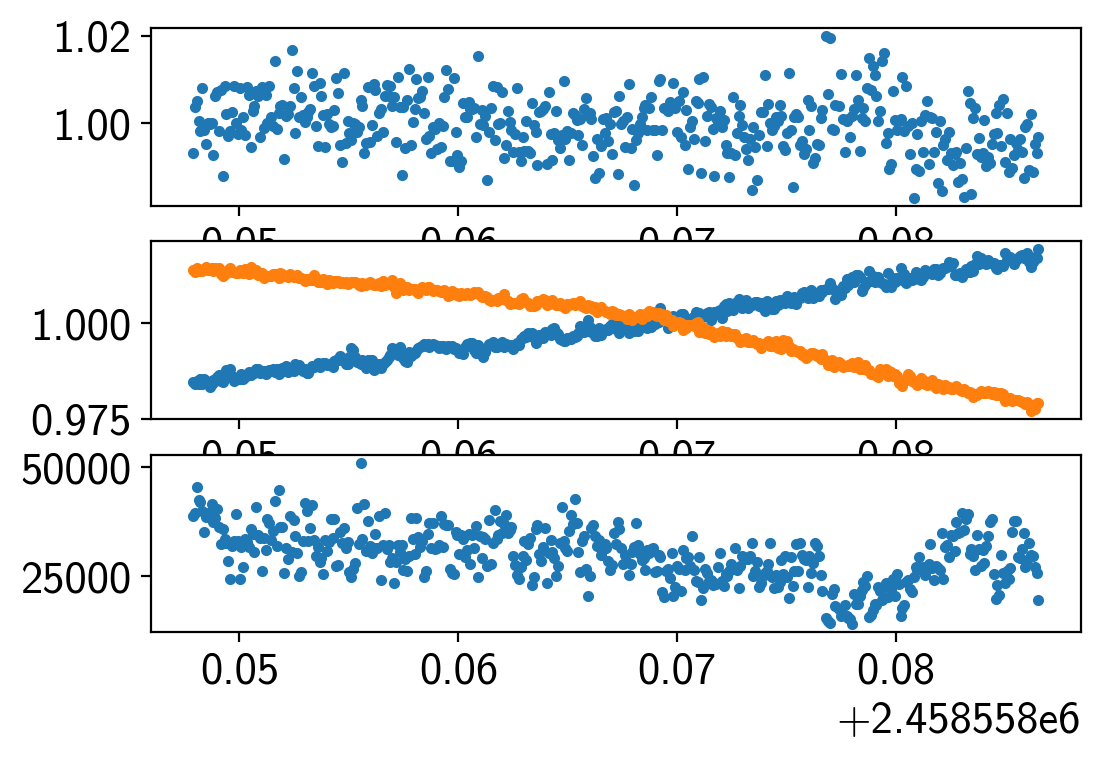

In [3]:
fp = '../data/20190315-TNT-TOI488_01-i.txt'
df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split())

time, flux, cenx, ceny, peak = df.values.T

time += 2400000.5
flux /= np.median(flux)

fig, axs = pl.subplots(3, 1)
axs[0].plot(time, flux, '.')
axs[1].plot(time, cenx/cenx.mean(), '.')
axs[1].plot(time, ceny/ceny.mean(), '.')
axs[2].plot(time, peak, '.')

0


<Container object of 3 artists>

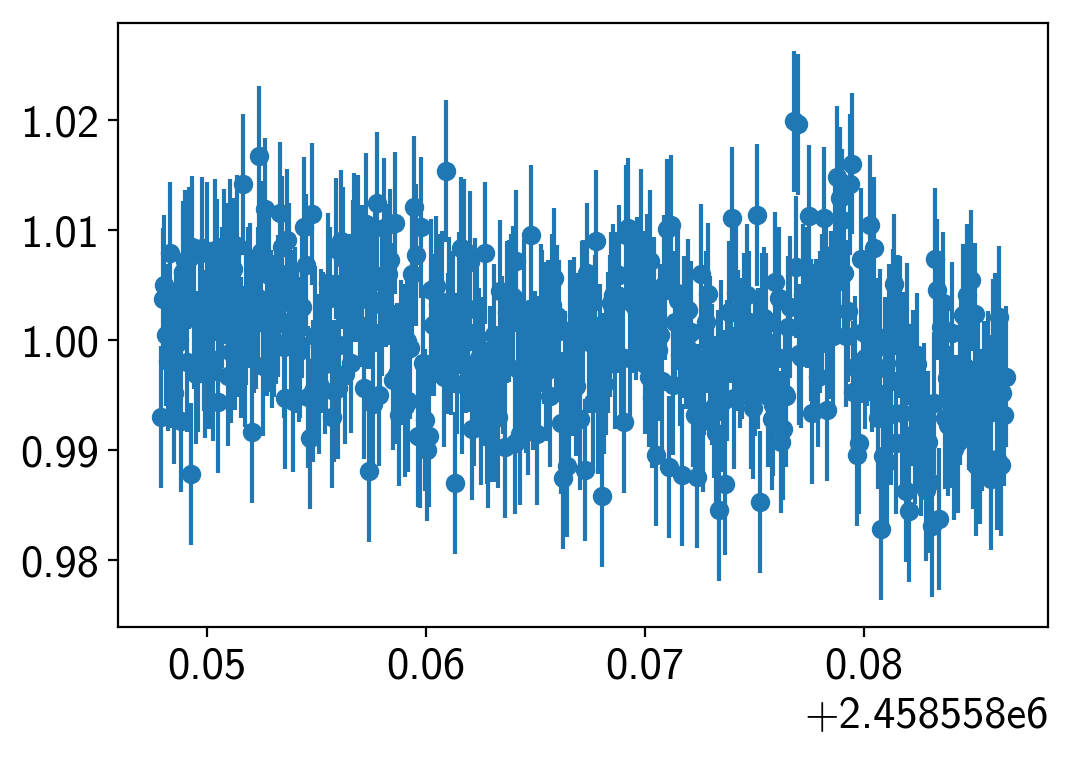

In [4]:
aux = np.c_[np.ones_like(time), time-time.min(), (time-time.min())**2, cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]
# aux = np.c_[np.ones_like(time), time-time.min(), cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]

idx = mad_outliers(flux)
print(idx.sum())

time, flux, aux = time[~idx], flux[~idx], aux[~idx]
unc = flux.std()

pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [5]:
# bin the data
##############

# fp = 'TOI-136_irsf_181007_j.csv'
# df = pd.read_csv(fp)

# idx = mad_outliers(df['flux'].values)
# print('omitting {} outliers'.format(idx.sum()))
# df = df[~idx]

# binsize_min = 5
# binsize = binsize_min / (60 * 24)
# print(np.diff(df['BJD_TDB']).mean()*86400)
# bins = np.arange(df['BJD_TDB'].min(), df['BJD_TDB'].max(), binsize)
# groups = df.groupby(np.digitize(df['BJD_TDB'], bins))
# df_binned = groups.mean()
# df = df_binned.copy()

# aux = df['airmass sky dx dy fwhm peak'.split()].values
# time, flux, unc = df['BJD_TDB flux err'.split()].values.T
# pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [6]:
band = 'i*'

planets = { 'TOI488.01': 
           { 
               'per': 1.198126,
               't0': 2458492.202,
               't14': 0.044,
               'rprs': 0.032
           }
          }

star = {
    'teff': [3332, 63],
    'logg': [4.9152799, 0.142281],
    'feh': [0.0, 0.5],
    'rad': [0.347, 0.021],
}

teff, logg, feh = [star.get(k) for k in 'teff logg feh'.split()]

ldp = limbdark.claret(band, teff[0], teff[1], logg[0], logg[1], feh[0], feh[1])
u1, u2 = ldp[0], ldp[2]
q1, q2 = u_to_q(u1, u2)

# logg = map_float(star['logg'])
# rad = map_float(star['rad'])
# n = 10000
# rad_s = rad[0] + np.random.randn(n) * rad[1]
# logg_s = logg[0] + np.random.randn(n) * logg[1]
# rho_s = rho(logg_s, rad_s)
# rhop = rho_s.mean(), rho_s.std()

# priors = dict(ld=ldp, rho=rhop)

pl_name = list(planets.keys())[0]
planet = planets[pl_name]
per, t0, t14, rprs = [planet.get(key) for key in 'per t0 t14 rprs'.split()]

while t0 < time.min():
    t0 += per
    
t0p = t0, 0.002097
perp = per, 0.000192
t14p = t14, 0.02
priors = dict(ld=ldp, t0=t0p, per=perp, t14=t14p)
# priors = None

init_params = get_init_params(per, t0, t14, rprs, b=0.5, q1=q1, q2=q2)
init_params['priors'] = priors
init_params['ls'] = np.log(flux.std())
pp.pprint(init_params)

{ 'b': 0.5,
  'k': 0.032,
  'ls': -5.046526579937407,
  'p': 1.198126,
  'priors': { 'ld': (0.2988, 0.0796419161020822, 0.3625, 0.07188850962031693),
              'per': (1.198126, 0.000192),
              't0': (2458558.098929994, 0.002097),
              't14': (0.044, 0.02)},
  'q1': 0.43731769,
  'q2': 0.22591864509299864,
  'r': 1.41,
  't0': 2458558.098929994,
  't14': 0.044}


In [7]:
# fit = TransitFit(init_params, pl_name, time, flux, unc=unc, aux=aux)
fit = TransitFit(init_params, pl_name, time, flux, aux=aux)

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


In [8]:
fit.fit_map()

Initial L-M least squares fit successful
[[Variables]]
    t0:   2.4586e+06 +/- 0        (0.00%) (init= 2458558)
    p:    1.198126 (fixed)
    k:    0.032 (fixed)
    r:    1.41 (fixed)
    b:    0.49265921 +/- 0        (0.00%) (init= 0.5)
    q1:   0.4373177 (fixed)
    q2:   0.2259186 (fixed)
    ls:  -5.046527 (fixed)
    c0:   0.28139752 +/- 0        (0.00%) (init= 0)
    c1:  -0.18871937 +/- 0        (0.00%) (init= 0)
    c2:  -4.48005460 +/- 0        (0.00%) (init= 0)
    c3:  -0.04950922 +/- 0        (0.00%) (init= 0)
    c4:  -0.21518391 +/- 0        (0.00%) (init= 0)
    c5:  -0.01034007 +/- 0        (0.00%) (init= 0)
None
Transit depth: 1024 [ppm]
Transit duration: 1.77 [h]
Log-probability: 1694.5372212410764
True
[[Variables]]
    t0:   2458558 (fixed)
    p:    1.198126 (fixed)
    k:    0.032 (fixed)
    r:    1.41 (fixed)
    b:    0.40012990 (init= 0.4926592)
    q1:   0.4373177 (fixed)
    q2:   0.2259186 (fixed)
    ls:  -5.12771697 (init=-5.046527)
    c0:   0.266968

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


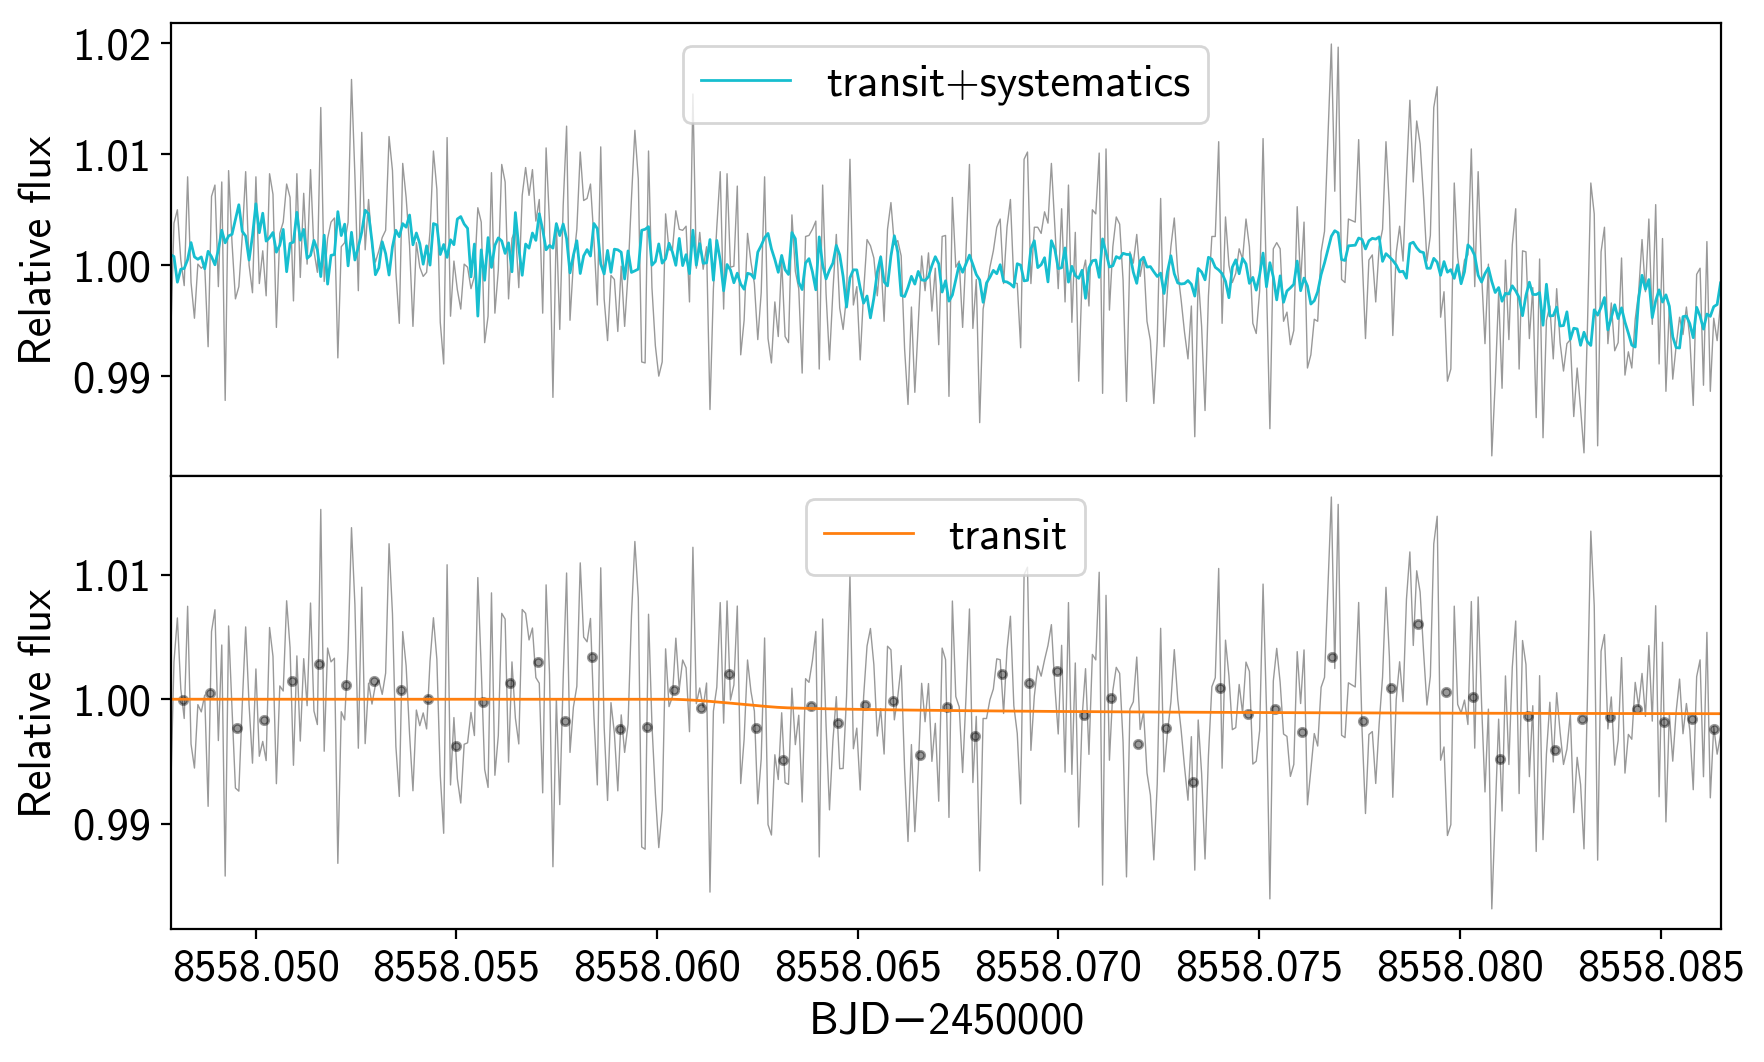

In [9]:
fit.plot_map()

In [10]:
# fit.fit_mcmc(two_stage=True)
fit.fit_mcmc(two_stage=True, steps=2000, nproc=4)

Running stage 1 MCMC (250 steps)...
Running production MCMC for 2000 steps...


../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))
../transitfit/util.py:72: RuntimeWarning: invalid value encountered in arcsin
  return (p / np.pi) * np.arcsin( alpha / np.sin(np.deg2rad(i)) / a )
../transitfit/util.py:72: RuntimeWarning: invalid value encountered in arcsin
  return (p / np.pi) * np.arcsin( alpha / np.sin(np.deg2rad(i)) / a )
../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))
../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))
../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))
../transitfit/util.py:72: RuntimeWarning: invalid value encountered in arcsin
  return (p / np.pi) * np.arcsin( alpha / np.sin(np.deg2rad(i)) / a )
../transitfit/util.py:72: RuntimeWarning: invalid value encountered in arcsin
  return (p / 

[[Variables]]
    t0:   2.4586e+06 +/- 0.002240 (0.00%) (init= 2458558)
    p:    1.19813152 +/- 0.000209 (0.02%) (init= 1.198126)
    k:    0.04172123 +/- 0.031481 (75.46%) (init= 0.032)
    r:    5.40680951 +/- 10.88357 (201.29%) (init= 1.41)
    b:    0.41848615 +/- 0.326274 (77.97%) (init= 0.4001299)
    q1:   0.43737626 +/- 0.139271 (31.84%) (init= 0.4373177)
    q2:   0.22571451 +/- 0.039963 (17.71%) (init= 0.2259186)
    ls:  -5.12254244 +/- 0.032190 (0.63%) (init=-5.127717)
    c0:   0.26709870 +/- 0.364167 (136.34%) (init= 0.266969)
    c1:  -0.28296402 +/- 0.203397 (71.88%) (init=-0.2051083)
    c2:  -3.45889018 +/- 4.751077 (137.36%) (init=-3.459179)
    c3:  -0.03807156 +/- 0.226452 (594.81%) (init=-0.05473488)
    c4:  -0.20381063 +/- 0.248106 (121.73%) (init=-0.1956386)
    c5:  -0.00992574 +/- 0.002030 (20.46%) (init=-0.01051931)
None
FIT_MCMC elapsed time: 123 sec


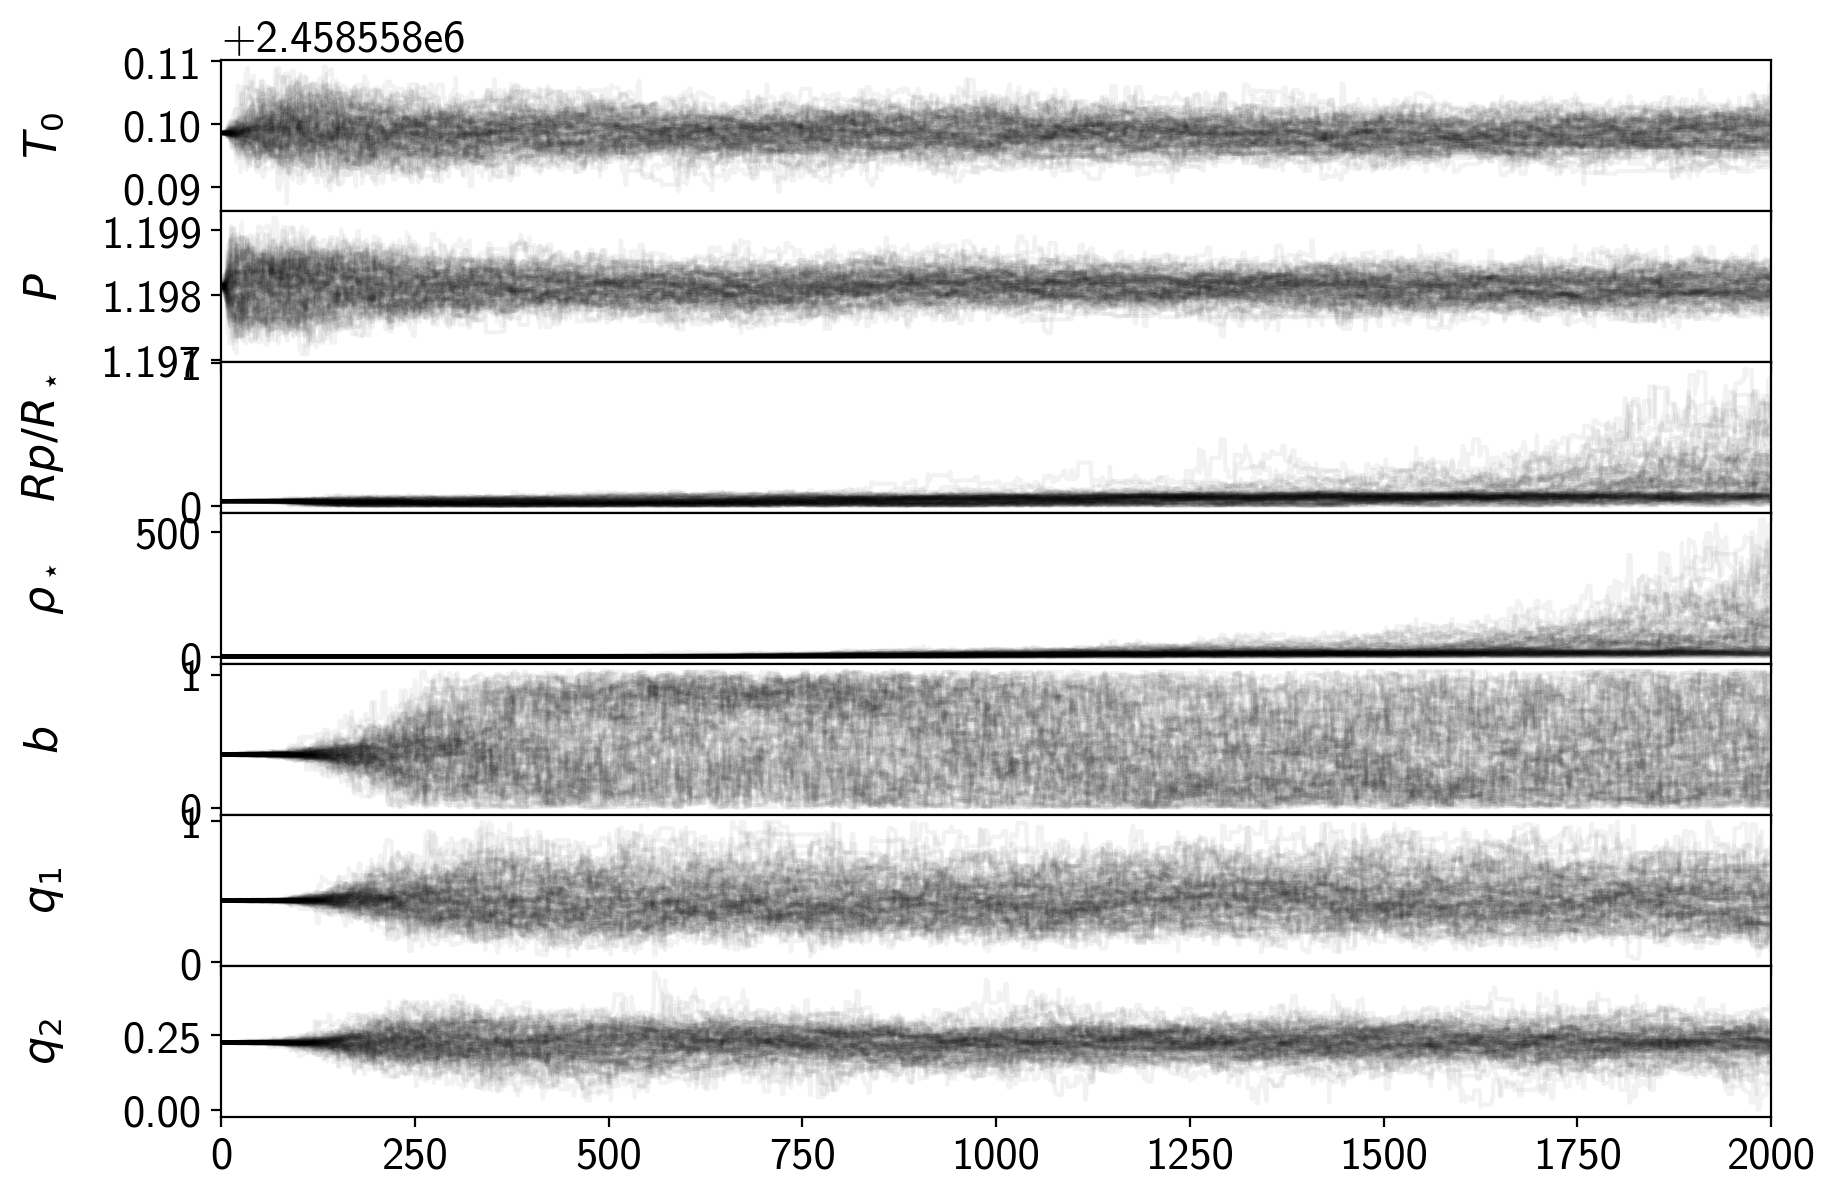

In [11]:
fit.plot_trace()

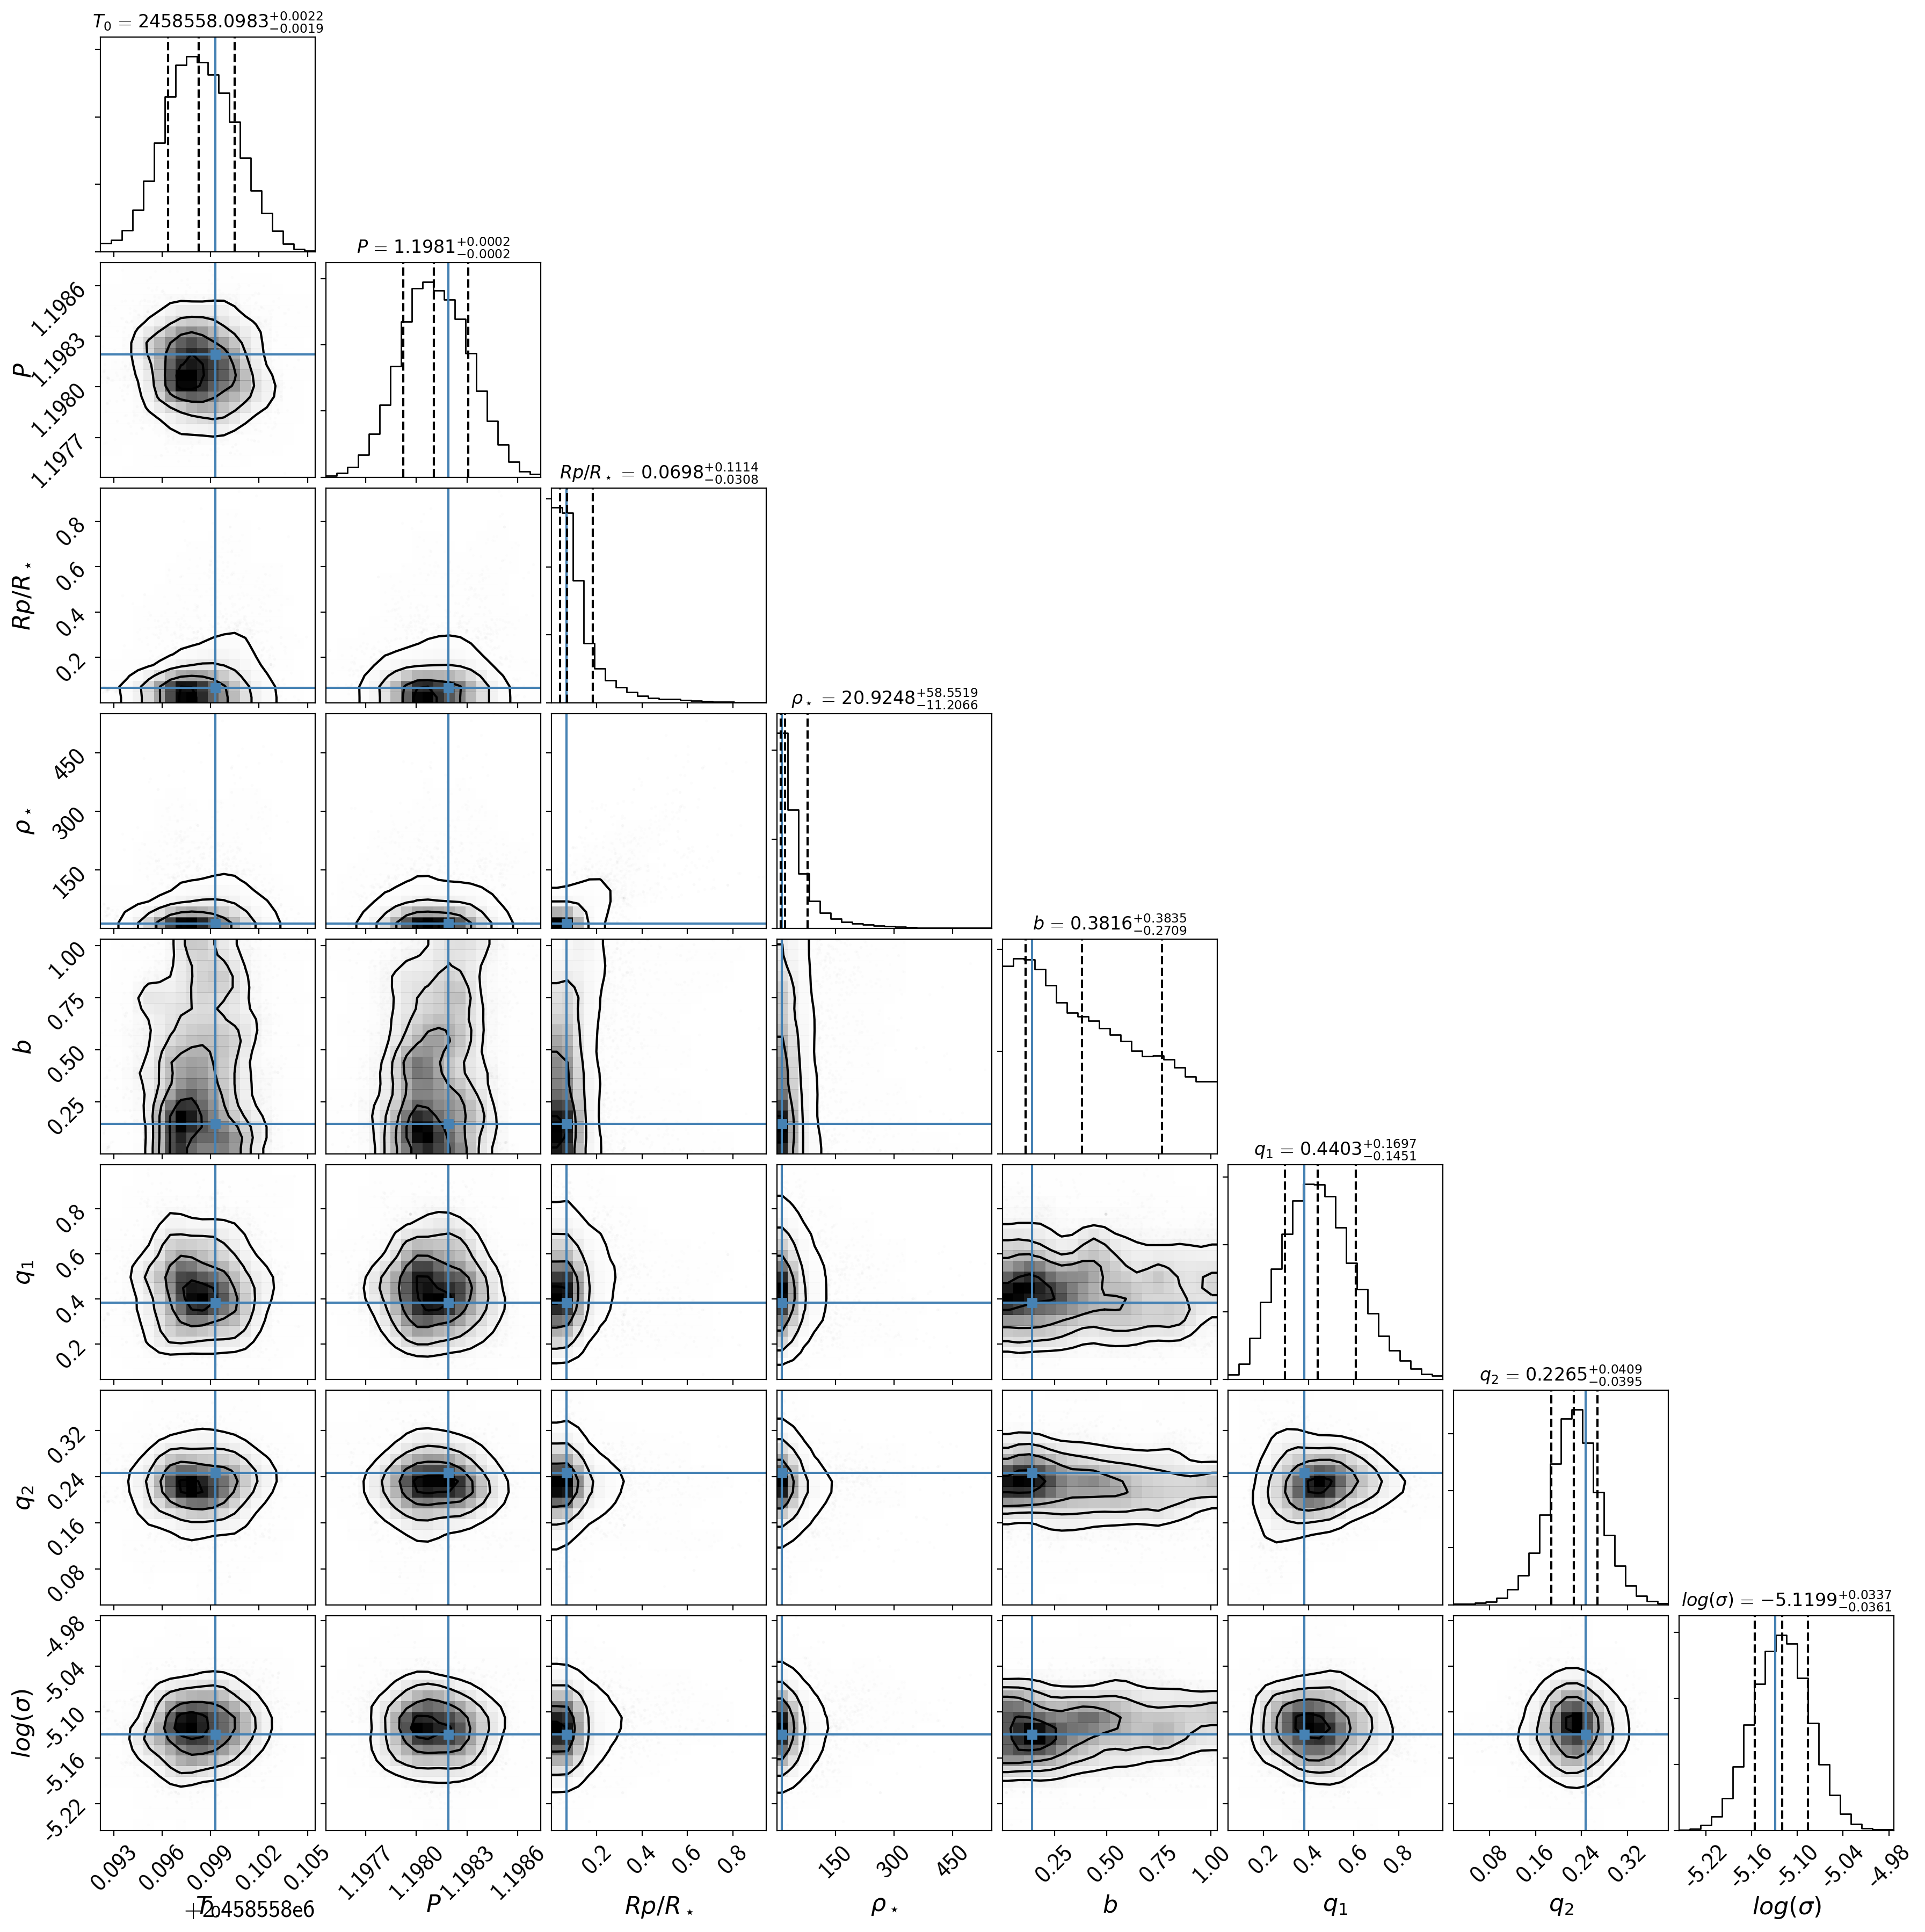

In [12]:
fit.burn_thin(burn=1500, thin=10)
fit.plot_corner()

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


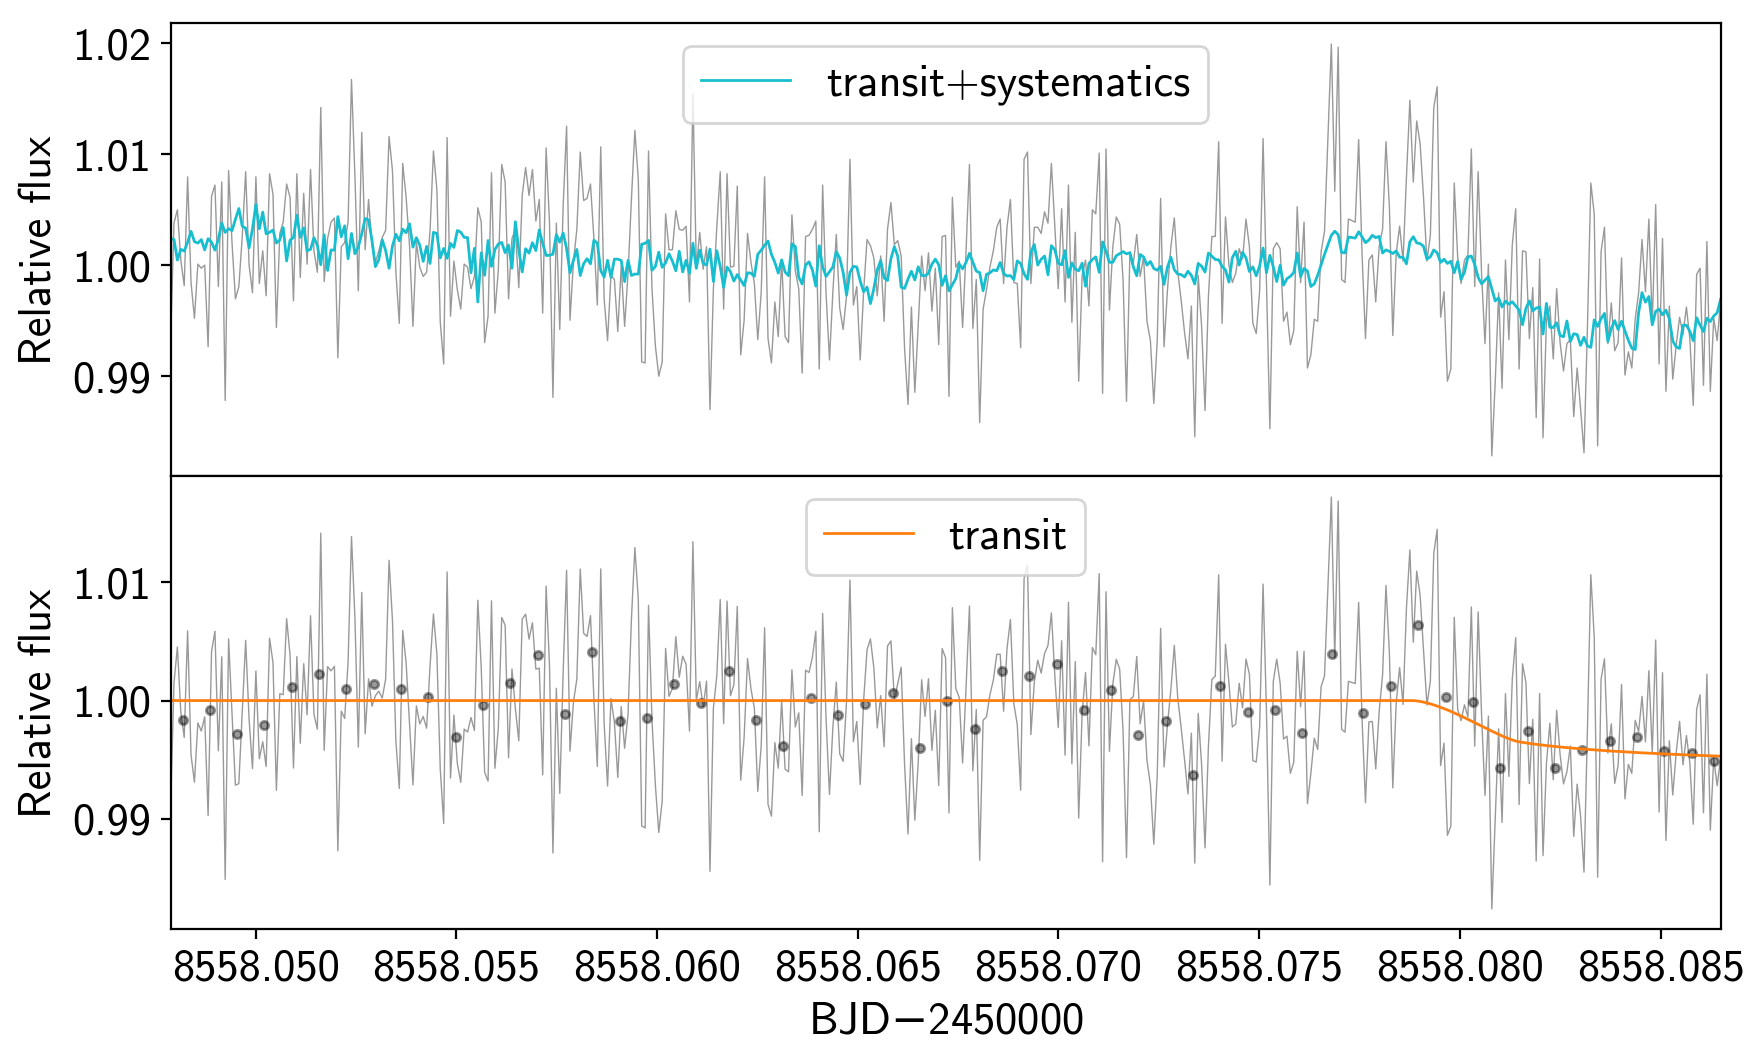

In [13]:
fit.plot_map()

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


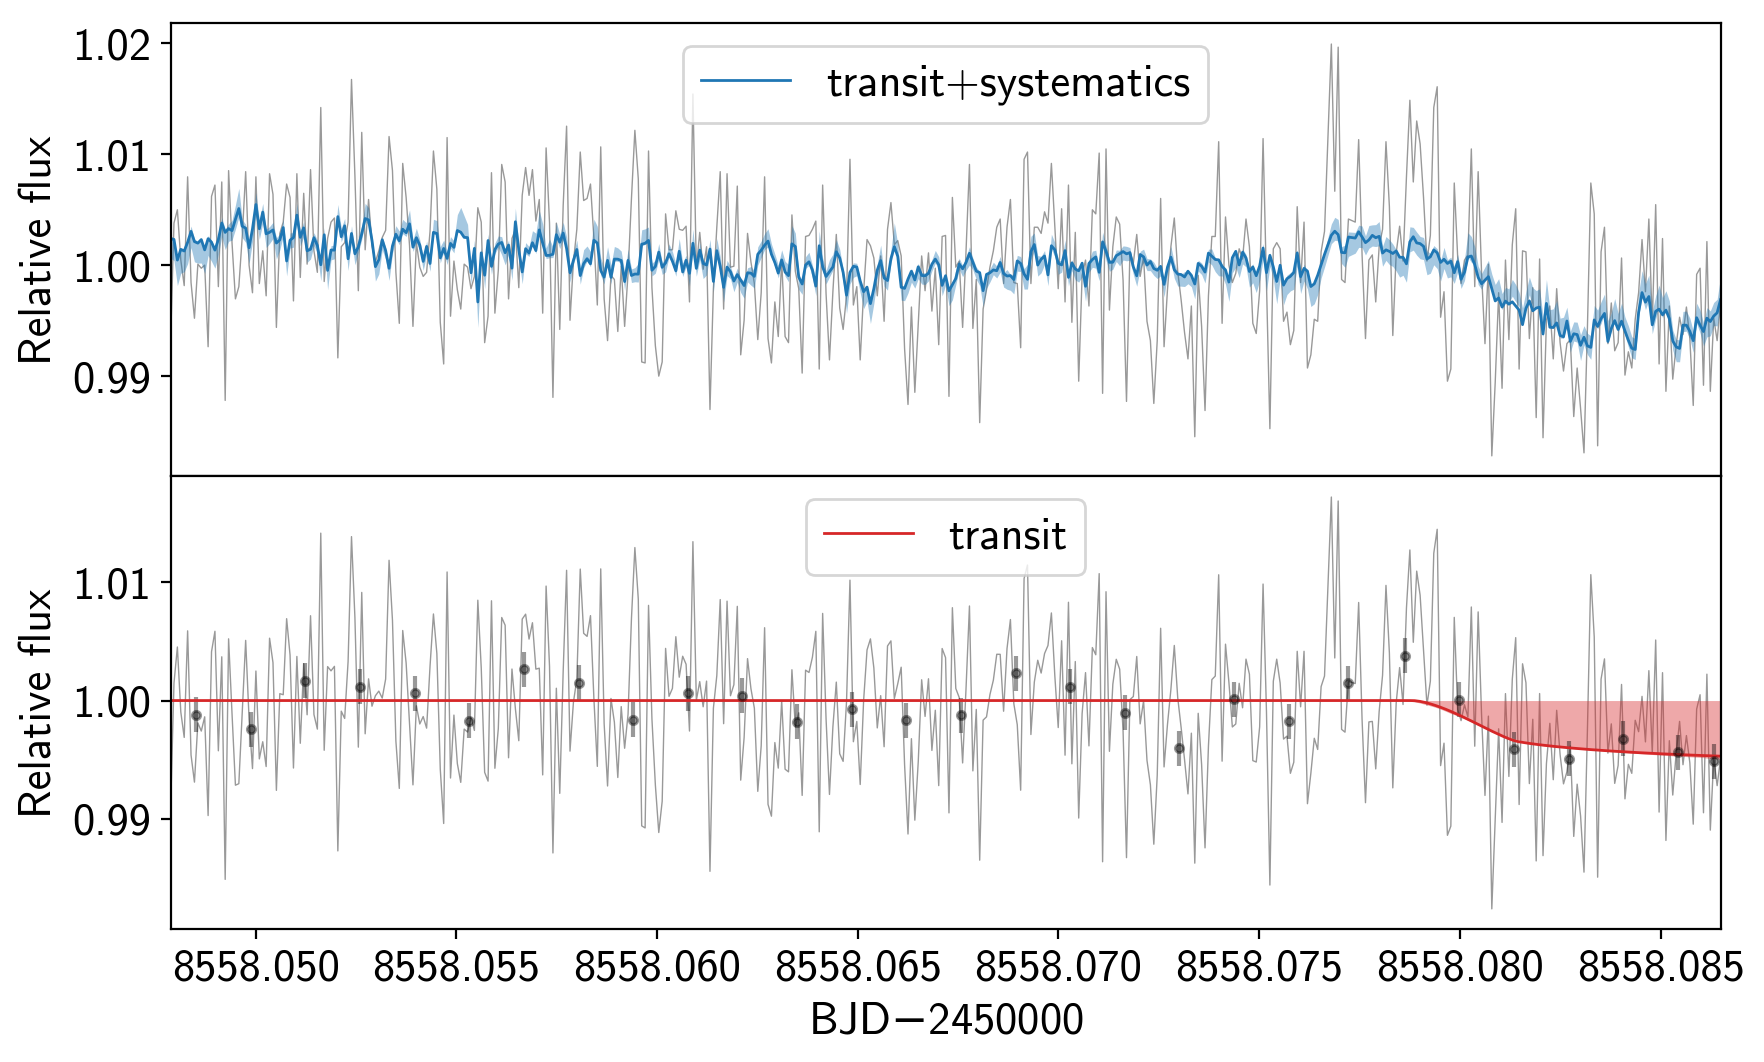

In [14]:
fig, axs = pl.subplots(2, 1, figsize=(10,6), sharex=True, sharey=False)
fit.plot_mcmc(binsize=16, c1='C0', c2='C3', sig=1, axs=axs)
# pl.setp(axs[1], ylim=(0.85,1.05))

In [15]:
fit.get_df(*star['rad']).describe()

../transitfit/util.py:79: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt( (1 - k)**2 - b**2 )


t0            p             k            r            b  \
count  5.000000e+03  5000.000000  5.000000e+03  5000.000000  5000.000000   
mean   2.458558e+06     1.198112  1.100602e-01    45.091115     0.422045   
std    2.074141e-03     0.000192  1.159504e-01    60.794068     0.286903   
min    2.458558e+06     1.197465  3.282933e-08     0.410052     0.001226   
25%    2.458558e+06     1.197979  5.017823e-02    12.595174     0.172086   
50%    2.458558e+06     1.198103  6.984148e-02    20.924792     0.381629   
75%    2.458558e+06     1.198249  1.243438e-01    53.656467     0.650170   
max    2.458558e+06     1.198737  9.477361e-01   551.156744     1.030612   

                q1           q2           ls           c0           c1  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.451553     0.226331    -5.120484     0.197373    -0.331688   
std       0.154580     0.043721     0.034527     0.446078     0.215324   
min       0.042521     0.017756    -5.255189    -1.180494    -1.023721   
25%       0.339970     0.201586    -5.144029    -0.110835    -0.478849   
50%       0.440302     0.226463    -5.119905     0.203910    -0.323108   
75%       0.547510     0.252999    -5.097300     0.510374    -0.186217   
max       0.996655     0.390675    -4.973415     1.807370     0.276657   

           ...                c4           c5        rstar       pl_rad  \
count      ...       5000.000000  5000.000000  5000.000000  5000.000000   
mean       ...         -0.162043    -0.009667     0.346976     4.167762   
std        ...          0.339579     0.002004     0.021149     4.418578   
min        ...         -1.291984    -0.016205     0.263241     0.000001   
25%        ...         -0.403065    -0.011076     0.332245     1.875732   
50%        ...         -0.166239    -0.009697     0.347021     2.634910   
75%        ...          0.076494    -0.008268     0.361375     4.701923   
max        ...          0.971774    -0.002910     0.426280    37.995467   

                 a          inc          t14          t23        shape  \
count  5000.000000  5000.000000  5000.000000  4466.000000  4466.000000   
mean     13.097901    87.822075     0.032325     0.027533     0.789991   
std       5.148772     2.017902     0.013324     0.013262     0.172268   
min       3.145654    71.739649     0.003368     0.000598     0.031349   
25%       9.850805    87.043405     0.023321     0.018435     0.736235   
50%      11.666607    88.307542     0.031148     0.028227     0.852422   
75%      15.970778    89.194603     0.037536     0.033307     0.895044   
max      34.718127    89.994705     0.091908     0.086841     1.000000   

              max_k  
count  4.466000e+03  
mean   1.301607e-01  
std    1.350887e-01  
min    7.781158e-08  
25%    5.538449e-02  
50%    7.966769e-02  
75%    1.519177e-01  
max    9.392070e-01  

[8 rows x 22 columns]